In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/Năm 3/03. NLP/NLP - Đồ án cuối kỳ'

# **Thư viện**

In [ ]:
!pip install pyvi

In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import copy
import gensim
import emoji

from pyvi import ViTokenizer, ViPosTagger
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# Maxent model
from nltk.classify import MaxentClassifier
from nltk.classify.util import accuracy

# Warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('default')

# **1. EDA & Tiền xử lý**


## **1.1. EDA (Explanatory Data Analysis)**

In [ ]:
train = pd.read_excel(folder + '/UIT-VSMEC' + '/train_nor_811.xlsx', index_col=0)
test = pd.read_excel(folder + '/UIT-VSMEC' + '/test_nor_811.xlsx', index_col=0)

In [ ]:
train

,Emotion,Sentence
188,Other,cho mình xin bài nhạc tên là gì với ạ
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
825,Other,nhìn mặt héo queo luôn
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
363,Enjoyment,thích thân hình boss rồi nhan 😌


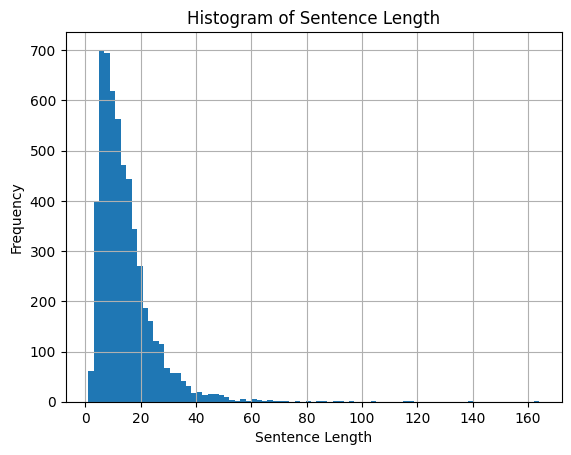

In [ ]:
# Check padding
length = [len(t.split(' ')) for t in train['Sentence']]
plt.hist(length, bins = len(set(length)))
plt.title("Histogram of Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

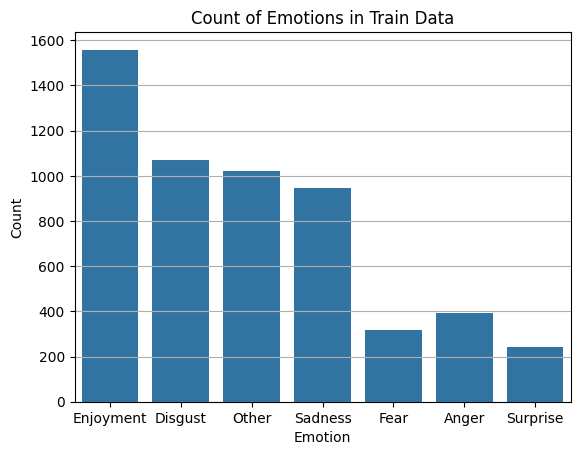

In [ ]:
sns.countplot(x='Emotion', data=train, order=test['Emotion'].value_counts().index)
plt.title("Count of Emotions in Train Data")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

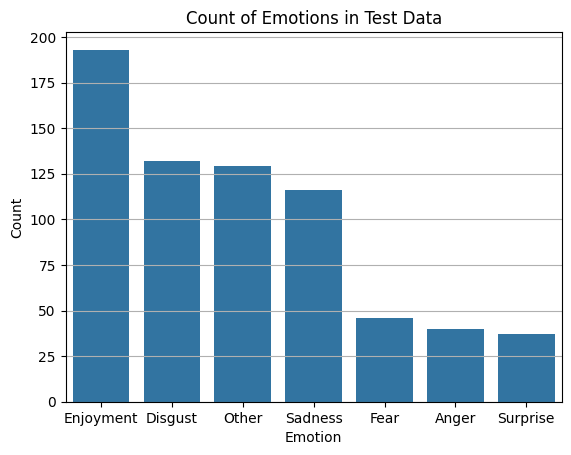

In [ ]:
sns.countplot(x='Emotion', data=test, order=test['Emotion'].value_counts().index)
plt.title("Count of Emotions in Test Data")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

Có thể thấy dữ liệu của tập train và tập test có số nhãn khá mất cân bằng

In [ ]:
# POS Tagging
def pos_tag_and_count(text):
    words, tags = ViPosTagger.postagging(text)
    tag_counts = {}
    for tag in tags:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
    return tag_counts

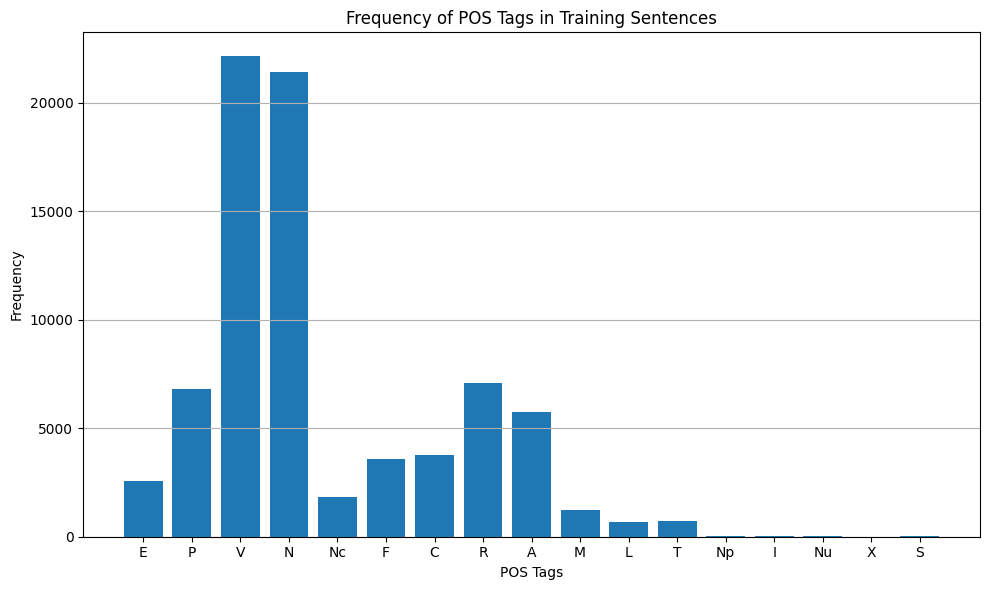

In [ ]:
all_tag_counts = {}

for i in range(len(train)):
    sentence = train['Sentence'].iloc[i]
    pos_tag_counts = pos_tag_and_count(sentence)
    for tag, count in pos_tag_counts.items():
        if tag in all_tag_counts:
            all_tag_counts[tag] += count
        else:
            all_tag_counts[tag] = count

tags = list(all_tag_counts.keys())
frequencies = list(all_tag_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(tags, frequencies)
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.title("Frequency of POS Tags in Training Sentences")
plt.xticks()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## **1.2. Tiền xử lý**
(nguồn tham khảo: https://github.com/hieugiaosu/Vietnamese-Sentiment-Analysis-UIT-VSMEC-DATASET-/blob/main/sentiment.ipynb)

### **1.2.1. Tokenize**

In [ ]:
stopwords = []
with open(folder + '/vietnamese-stopwords.txt', 'r') as f:
    for line in f:
        stopwords.append(line.strip())
# stopwords

In [ ]:
teencodes = {}
with open(folder + '/teencode4.txt','r') as file:
    file = file.read()
    lines = file.split('\n')
    for line in lines:
        elements = line.split('\t')
        if len(elements) == 2:
            teencodes[elements[0]] = elements[1]
# teencodes

In [ ]:
def preprocess_teencodes(sentence):
    for key, value in teencodes.items():
        sentence = re.sub(r'\b{}\b'.format(key), value, sentence)
    return sentence

In [ ]:
def preprocess_emoji(sentence):
    emotion_dict = {
        '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
        '(-_-)|(-\.-)':'😐',':v':'_pacman_smile_','(:|;|=)+(\'|`|\")+(\)|\]|>)+':'🥲','(:|;|=)+(\'|`|\")+(\(|\[|<)+':'😢',
        '@@':'😵‍💫','đc':'được','đk':'được','bik':'biết','ngừi':'người','hix':'hic','lm':'làm'
    }
    for key, value in emotion_dict.items():
        sentence = re.sub(key,value,sentence)
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r":(.*?):",r" _\1_ ",sentence)
    sentence = re.sub(r'([!@#$%^&*()_+={}:;"\'<>,?/\|~-])\1+',r'\1',sentence)
    return sentence

In [ ]:
def tokenize(sentence):
    start_token = ' _s_ '
    end_token = ' _e_ '
    sentence = sentence.lower()

    # Preprocess Emoji
    sentence = preprocess_emoji(sentence)

    # Preprocess teencodes
    sentence = preprocess_teencodes(sentence)

    sentence = start_token + sentence + end_token
    return ViTokenizer.tokenize(sentence).split()

In [ ]:
def remove_stopwords(words):
    new_words = [word for word in words if re.sub("_", " ", word) not in stopwords]
    return new_words

In [ ]:
train['Text'] = train['Sentence'].apply(tokenize)
train['Text'] = train['Text'].apply(remove_stopwords)
train

,Emotion,Sentence,Text
188,Other,cho mình xin bài nhạc tên là gì với ạ,"[_s_, nhạc, _e_]"
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,"[_s_, đường, nhà_cụ, cụ, cấm, người_ta, đỗ, .,..."
825,Other,nhìn mặt héo queo luôn,"[_s_, mặt, héo, queo, _e_]"
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,"[_s_, tao, đi, xe_máy, xe, đi, phi_mẹ, quán, n..."
363,Enjoyment,thích thân hình boss rồi nhan 😌,"[_s_, thân_hình, boss, nhan, _relieved_face_, ..."


In [ ]:
test['Text'] = test['Sentence'].apply(tokenize)
test['Text'] = test['Text'].apply(remove_stopwords)
test

,Emotion,Sentence,Text
713,Sadness,người ta có bạn bè nhìn vui thật,"[_s_, người_ta, bạn_bè, vui, _e_]"
1827,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật,"[_s_, nghỉ, viêc, mói, goi, kỷ_luật, _e_]"
1166,Disgust,kinh vãi 😡,"[_s_, kinh, vãi, _enraged_face_, _e_]"
228,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,"[_s_, lắm, đi, sợ, đè_bẹp, _slightly_smiling_f..."
1942,Anger,bố không thích nộp đấy mày thích ý kiến không,"[_s_, bố, nộp, đấy, mày, ý_kiến, _e_]"
...,...,...,...
432,Sadness,lúc thì cuốc đất è cổ ra không có giun mà câu ...,"[_s_, cuốc, đất, è_cổ, giun, câu, cá, _unamuse..."
178,Enjoyment,các bác dẫn crush qua cây sữa nay mà hứng nước...,"[_s_, crush, sữa, hứng, nước_đái, ve_nha, haha..."
1863,Surprise,vợ chồng rồi mà trong sáng như này chỉ có tron...,"[_s_, vợ_chồng, trong_sáng, phim, _face_with_t..."
476,Other,bep này vào binh dương dùng xuất,"[_s_, bep, binh, dương, xuất, _e_]"


### **1.2.2. Mã hóa Emotion**

In [ ]:
emotions = ['Surprise', 'Sadness', 'Anger', 'Fear', 'Enjoyment', 'Disgust', 'Other']
emotion_to_num = dict({v:k for k,v in enumerate(emotions)})
num_to_emotion = dict({k:v for k,v in enumerate(emotions)})
train['Emotion'] = train['Emotion'].apply(lambda x: emotion_to_num[x])
test['Emotion'] = test['Emotion'].apply(lambda x: emotion_to_num[x])

In [ ]:
emotion_to_num

{'Surprise': 0,
 'Sadness': 1,
 'Anger': 2,
 'Fear': 3,
 'Enjoyment': 4,
 'Disgust': 5,
 'Other': 6}

In [ ]:
num_to_emotion

{0: 'Surprise',
 1: 'Sadness',
 2: 'Anger',
 3: 'Fear',
 4: 'Enjoyment',
 5: 'Disgust',
 6: 'Other'}

### **1.2.3. Tăng cường dữ liệu (data augmentation)**
Các từ ngẫu nhiên trong câu bị thay thế bằng unknown tag theo một tỷ lệ

In [ ]:
def createUnknownData(df,unknown_rate,unknown_tag ='_unk_'):
    mask_df = pd.DataFrame(columns=['Emotion','Text'])
    for row in df.iterrows():
        mask_array = np.random.choice(
            [1,0],size=len(row[1]['Text']),p=[unknown_rate,1-unknown_rate]
        )
        mask_array[0]=0
        mask_array[-1]=0
        if np.sum(mask_array) > 0:
            sentence = copy.deepcopy(row[1]['Text'])
            for idx in range(len(row[1]['Text'])):
                if mask_array[idx] == 1: sentence[idx] = unknown_tag
            mask_df.loc[len(mask_df.index)] = [copy.deepcopy(row[1]['Emotion']),sentence]
    return mask_df

In [ ]:
unk_frame = createUnknownData(train,unknown_rate=0.01,unknown_tag ='_unk_')
unk_frame

,Emotion,Text
0,1,"[_s_, per, đi, khóc, 1, _unk_, thoải_mái, ., đ..."
1,0,"[_s_, per, mí, _unk_, tổ, sừng, _e_]"
2,6,"[_s_, bồi_thường, thiệt_hại, trầy_xước, thân, ..."
3,5,"[_s_, mệt, _unk_, khỏe, ., _e_]"
4,4,"[_s_, nói_chuyện, nhật, !, 1, khoa_học, ,, giá..."
...,...,...
344,1,"[_s_, 15, cắp, sách, đi, học, 2, ,, 5, động, s..."
345,4,"[_s_, _unk_, hành_động, ., time, câu, trả_lời,..."
346,3,"[_s_, per, đi, trường, địt, con_mẹ, nổi, _unk_..."
347,1,"[_s_, hôm_qua, tao, xong, ngất_xỉu, tĩnh, chún..."


In [ ]:
new_train_frame = pd.concat([train[['Emotion', 'Text']], unk_frame])
new_train_frame

,Emotion,Text
188,6,"[_s_, nhạc, _e_]"
166,5,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,5,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,4,"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,4,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...
344,1,"[_s_, 15, cắp, sách, đi, học, 2, ,, 5, động, s..."
345,4,"[_s_, _unk_, hành_động, ., time, câu, trả_lời,..."
346,3,"[_s_, per, đi, trường, địt, con_mẹ, nổi, _unk_..."
347,1,"[_s_, hôm_qua, tao, xong, ngất_xỉu, tĩnh, chún..."


corpus (dùng trong Word2Vec): danh sách các câu, mỗi câu là một danh sách các từ (đã được tiền xử lý)

In [ ]:
corpus = []
for sentence in new_train_frame['Text']:
    corpus.append(sentence)
len(corpus)

5897

In [ ]:
start_token = '_s_'
end_token = '_e_'
unknown_token = '_unk_'

### **1.2.4. Xử lý dữ liệu mất cân bằng**

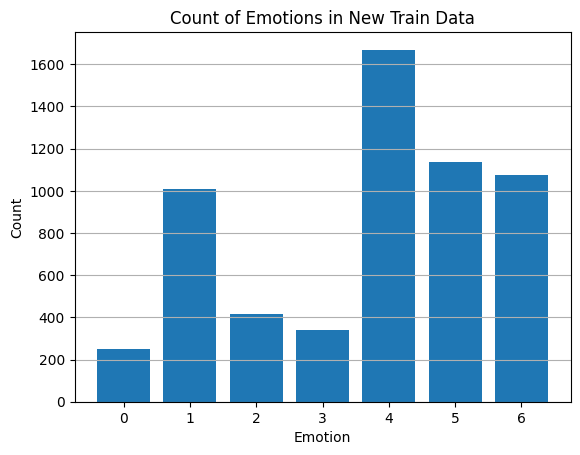

In [ ]:
plt.bar(new_train_frame['Emotion'].value_counts().index, new_train_frame['Emotion'].value_counts().values)
plt.title('Count of Emotions in New Train Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

Phương pháp random undersampling: Giảm tỷ lệ mẫu dữ liệu thuộc một cảm xúc cụ thể trong tập train và sau đó chuyển một phần dữ liệu bị loại bỏ sang tập test.

Thực hiện undersampling với các mẫu có nhãn là Enjoyment vì nhãn này xuất hiện nhiều nhất trong tập train.

In [ ]:
drop_lst = []
for i in new_train_frame.index[new_train_frame['Emotion']==emotion_to_num['Enjoyment']]:
    if np.random.uniform(0,1)<0.4: # random dưới 40% mẫu trong tập train có nhãn là 'Enjoyment'
        drop_lst.append(i)

drop_df = new_train_frame[new_train_frame.index.isin(drop_lst)]
train_df = new_train_frame.drop(new_train_frame.index[drop_lst])
test_df = pd.concat([test,drop_df])

In [ ]:
duplicate = new_train_frame[
    (new_train_frame['Emotion']==emotion_to_num['Anger']) |
    (new_train_frame['Emotion']==emotion_to_num['Fear']) |
    (new_train_frame['Emotion']==emotion_to_num['Surprise'])
]
train_df = pd.concat([train_df,duplicate,duplicate])

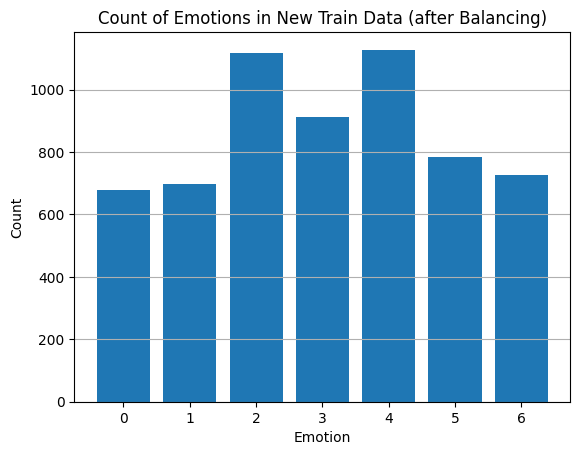

In [ ]:
plt.bar(train_df['Emotion'].value_counts().index, train_df['Emotion'].value_counts().values)
plt.title('Count of Emotions in New Train Data (after Balancing)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

Phân phối các nhãn trở nên cân bằng hơn.

In [ ]:
train_df.shape

(6044, 2)

In [ ]:
test_df.shape

(2789, 3)

# **2. Chuyển đổi thành vector và huấn luyện mô hình**

## **2.1. Phương pháp Word2Vec**

Training Word2Vec

In [ ]:
model = gensim.models.Word2Vec(corpus,vector_size=100, window=5, min_count=1, workers=4,epochs=100)

In [ ]:
vector_size = 100

In [ ]:
# # Lưu model word2vec
# with open(folder + '/word2vec_model.pkl', 'wb') as file:
#     pickle.dump(model, file)

In [ ]:
key_to_index = model.wv.key_to_index
index_to_key = model.wv.index_to_key

In [ ]:
def get_sentence_vector(sentence):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)
    else:
        return [0] * model.vector_size  # Trả về vector 0 nếu không có từ nào trong mô hình

In [ ]:
train_df['vector'] = train_df['Text'].apply(get_sentence_vector)
test_df['vector'] = test_df['Text'].apply(get_sentence_vector)

X = np.vstack(train_df['vector'].values)
y = train_df['Emotion']

X_test_data = np.vstack(test_df['vector'].values)

### **2.1.1. Huấn luyện mô hình Logistic Regression và SVM**

K-fold cross validation

In [ ]:
# Hàm thực hiện k-fold cross-validation với Word2Vec
def cross_validate_with_w2v(model, params, X, y, kf):
    best_params = None
    best_score = 0
    results = []

    for param in params:
        scores = []

        # K-fold cross-validation
        for train_index, val_index in kf.split(X):
            # Tách dữ liệu train/test theo fold
            X_train = X[train_index]
            X_val = X[val_index]
            y_train = y.iloc[train_index]
            y_val = y.iloc[val_index]

            # Cập nhật tham số cho model
            model.set_params(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))

        # Tính điểm trung bình cho bộ tham số
        avg_score = np.mean(scores)
        results.append((param, avg_score))
        if avg_score > best_score:
            best_score = avg_score
            best_params = param

    return best_params, best_score, results

In [ ]:
# Các tham số để thử nghiệm
param_grid_lr = {'C': [0.1, 1, 10]}  # Logistic Regression
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # SVM

# Khởi tạo k-fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Logistic Regression
lr_params = [{'C': c} for c in param_grid_lr['C']]
lr_model = LogisticRegression(max_iter=1000)
print("Tuning Logistic Regression...")
best_params_lr, best_score_lr, results_lr = cross_validate_with_w2v(
    lr_model, lr_params, X, y, kf
)
print(f"Best Logistic Regression params: {best_params_lr}")
print(f"Accuracy: {best_score_lr:.4f}")

# SVM
svm_params = [{'C': c, 'kernel': k} for c in param_grid_svm['C'] for k in param_grid_svm['kernel']]
svm_model = SVC()
print("\nTuning SVM...")
best_params_svm, best_score_svm, results_svm = cross_validate_with_w2v(
    svm_model, svm_params, X, y, kf
)
print(f"Best SVM params: {best_params_svm}")
print(f"Accuracy: {best_score_svm:.4f}")


Tuning Logistic Regression...
Best Logistic Regression params: {'C': 1}
Accuracy: 0.5051

Tuning SVM...
Best SVM params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.6711


Sử dụng siêu tham số tốt nhất để huấn luyện mô hình trên tập train và đánh giá trên tập test

In [ ]:
# Logistic Regression
best_lr_model = LogisticRegression(C=best_params_lr['C'], max_iter=1000)
best_lr_model.fit(X, y)

y_test_pred_lr = best_lr_model.predict(X_test_data)

print('Logistic Regression (Word2Vec):\n')
print(classification_report(test_df['Emotion'], y_test_pred_lr))

# SVM
best_svm_model = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'], probability=True)
best_svm_model.fit(X, y)

y_test_pred_svm = best_svm_model.predict(X_test_data)

print('\nSVM (Word2Vec):\n')
print(classification_report(test_df['Emotion'], y_test_pred_svm))

Logistic Regression (Word2Vec):

              precision    recall  f1-score   support

           0       0.25      0.61      0.35       127
           1       0.65      0.50      0.57       432
           2       0.25      0.66      0.36       173
           3       0.42      0.62      0.50       172
           4       0.67      0.61      0.64       913
           5       0.46      0.28      0.35       502
           6       0.39      0.24      0.30       470

    accuracy                           0.48      2789
   macro avg       0.44      0.50      0.44      2789
weighted avg       0.52      0.48      0.48      2789


SVM (Word2Vec):

              precision    recall  f1-score   support

           0       0.44      0.82      0.57       127
           1       0.76      0.69      0.72       432
           2       0.56      0.83      0.67       173
           3       0.76      0.78      0.77       172
           4       0.80      0.76      0.78       913
           5       0.70    

In [ ]:
# with open(folder + '/logistic_w2v.pkl', 'wb') as file:
#     pickle.dump(best_lr_model, file)

# with open(folder + '/svm_w2v.pkl', 'wb') as file:
#     pickle.dump(best_svm_model, file)

### **2.1.2. Huấn luyện mô hình Maxent (Maximum Entropy Model)**

In [ ]:
def format_data_for_maxent_w2v(X, y):
    formatted_data = []
    for i in range(X.shape[0]):
        features = tuple(X[i].tolist())
        formatted_data.append(({'features': features}, y.iloc[i]))
    return formatted_data

In [ ]:
formatted_data = format_data_for_maxent_w2v(X, y)

maxent_model = MaxentClassifier.train(formatted_data, algorithm='iis', max_iter=10, trace=1)

X_test_data = np.vstack(test_df['vector'].values)
y_test_pred_maxent = [maxent_model.classify({'features': tuple(vector.tolist())}) for vector in X_test_data]
test_data = format_data_for_maxent_w2v(X_test_data, test_df['Emotion'])

print("Maxent (Word2Vec):\n")
print(classification_report(test_df['Emotion'], y_test_pred_maxent))
print("Accuracy (nltk):", round(accuracy(maxent_model, test_data), 4))

  ==> Training (10 iterations)
Maxent (Word2Vec):

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       127
           1       0.99      0.48      0.65       432
           2       0.99      0.77      0.86       173
           3       0.99      0.73      0.84       172
           4       1.00      0.52      0.69       913
           5       1.00      0.47      0.64       502
           6       0.31      0.98      0.47       470

    accuracy                           0.62      2789
   macro avg       0.86      0.67      0.70      2789
weighted avg       0.87      0.62      0.66      2789

Accuracy (nltk): 0.6207


In [ ]:
# with open(folder + '/maxent_w2v.pkl', 'wb') as file:
#     pickle.dump(maxent_model, file)

## **2.2. Phương pháp TF-IDF**

### **2.2.1. Huấn luyện mô hình Logistic Regression và SVM**

K-fold cross validation

In [ ]:
# Hàm thực hiện k-fold cross-validation với TF-IDF vectorizer
def cross_validate_with_tfidf(model, params, X_raw, y, kf):
    best_params = None
    best_score = 0
    results = []

    for param in params:
        scores = []

        # K-fold cross-validation
        for train_index, val_index in kf.split(X_raw):
            # Tách dữ liệu train/test theo fold
            X_train_raw = [X_raw[i] for i in train_index]
            X_val_raw = [X_raw[i] for i in val_index]
            y_train = y.iloc[train_index]
            y_val = y.iloc[val_index]

            # Áp dụng TF-IDF vectorizer trên tập train và test trong fold này
            vectorizer = TfidfVectorizer()
            X_train = vectorizer.fit_transform([' '.join(text) for text in X_train_raw])
            X_val = vectorizer.transform([' '.join(text) for text in X_val_raw])

            # Cập nhật tham số cho model
            model.set_params(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))

        # Tính điểm trung bình cho bộ tham số
        avg_score = np.mean(scores)
        results.append((param, avg_score))
        if avg_score > best_score:
            best_score = avg_score
            best_params = param

    return best_params, best_score, results

In [ ]:
# Các tham số để thử nghiệm
param_grid_lr = {'C': [0.1, 1, 10]}  # Logistic Regression
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # SVM

# Khởi tạo k-fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Chuẩn bị dữ liệu
X_raw = train_df['Text'].tolist()
y = train_df['Emotion']

# Logistic Regression
lr_params = [{'C': c} for c in param_grid_lr['C']]
lr_model = LogisticRegression(max_iter=1000)
print("Tuning Logistic Regression...")
best_params_lr, best_score_lr, results_lr = cross_validate_with_tfidf(lr_model, lr_params, X_raw, y, kf)
print(f"Best Logistic Regression params: {best_params_lr}")
print(f"Accuracy: {best_score_lr:.4f}")

# SVM
svm_params = [{'C': c, 'kernel': k} for c in param_grid_svm['C'] for k in param_grid_svm['kernel']]
svm_model = SVC()
print("\nTuning SVM...")
best_params_svm, best_score_svm, results_svm = cross_validate_with_tfidf(svm_model, svm_params, X_raw, y, kf)
print(f"Best SVM params: {best_params_svm}")
print(f"Accuracy: {best_score_svm:.4f}")

Tuning Logistic Regression...
Best Logistic Regression params: {'C': 10}
Accuracy: 0.7086

Tuning SVM...
Best SVM params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.7386


Sử dụng siêu tham số tốt nhất để huấn luyện mô hình trên tập train và đánh giá trên tập test

In [ ]:
# Khởi tạo TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

In [ ]:
# Logistic Regression
best_lr_model = LogisticRegression(C=best_params_lr['C'], max_iter=1000)
best_lr_model.fit(X_train_tfidf, y)

y_test_pred_tf_lr = best_lr_model.predict(X_test_tfidf)

print("Logistic Regression (TF-IDF):")
print(classification_report(test_df['Emotion'], y_test_pred_tf_lr))


# SVM
best_svm_model = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'], probability=True)
best_svm_model.fit(X_train_tfidf, y)

y_test_pred_tf_svm = best_svm_model.predict(X_test_tfidf)

print("\nSVM (TF-IDF):")
print(classification_report(test_df['Emotion'], y_test_pred_tf_svm))

Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

           0       0.50      0.83      0.62       127
           1       0.85      0.72      0.78       432
           2       0.58      0.85      0.69       173
           3       0.75      0.90      0.81       172
           4       0.84      0.80      0.82       913
           5       0.75      0.68      0.71       502
           6       0.66      0.60      0.63       470

    accuracy                           0.74      2789
   macro avg       0.70      0.77      0.72      2789
weighted avg       0.76      0.74      0.75      2789


SVM (TF-IDF):
              precision    recall  f1-score   support

           0       0.60      0.82      0.69       127
           1       0.84      0.74      0.79       432
           2       0.77      0.82      0.80       173
           3       0.91      0.90      0.90       172
           4       0.84      0.86      0.85       913
           5       0.77      0.74

In [ ]:
# with open(folder + '/tfidf_vectorizer.pkl', 'wb') as file:
#     pickle.dump(vectorizer, file)

# with open(folder + '/logistic_tfidf.pkl', 'wb') as file:
#     pickle.dump(best_lr_model, file)

# with open(folder + '/svm_tfidf.pkl', 'wb') as file:
#     pickle.dump(best_svm_model, file)

### **2.2.2. Huấn luyện mô hình Maxent (Maximum Entropy Model)**

In [ ]:
def format_data_for_maxent_tfidf(X, y):
    formatted_data = []
    for i in range(X.shape[0]):
        features = tuple(X[i].toarray()[0].tolist())

        formatted_data.append(({'features': features}, y.iloc[i]))
    return formatted_data

In [ ]:
# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

train_data_tfidf = format_data_for_maxent_tfidf(X_train_tfidf, train_df['Emotion'])
test_data_tfidf = format_data_for_maxent_tfidf(X_test_tfidf, test_df['Emotion'])

maxent_classifier_tfidf = MaxentClassifier.train(train_data_tfidf, trace=0, algorithm='iis', max_iter=10)

y_test_pred_tf_maxent = [maxent_classifier_tfidf.classify({'features': tuple(vector.toarray()[0].tolist())}) for vector in X_test_tfidf]

print("\nMaxEnt (TF-IDF):")
print(classification_report(test_df['Emotion'], y_test_pred_tf_maxent))
print("Accuracy (nltk):", round(accuracy(maxent_classifier_tfidf, test_data_tfidf), 4))


MaxEnt (TF-IDF):
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       127
           1       0.99      0.41      0.58       432
           2       0.98      0.60      0.74       173
           3       0.98      0.58      0.73       172
           4       0.99      0.44      0.61       913
           5       0.99      0.38      0.55       502
           6       0.27      0.96      0.42       470

    accuracy                           0.54      2789
   macro avg       0.84      0.58      0.61      2789
weighted avg       0.85      0.54      0.58      2789

Accuracy (nltk): 0.5421


In [ ]:
# with open(folder + '/maxent_tfidf.pkl', 'wb') as file:
#     pickle.dump(maxent_classifier_tfidf, file)

# **3. Đánh giá**

## **3.1. Tổng hợp metrics đánh giá**

In [ ]:
def update_metrics(row_index, y_true, y_pred):
    metrics = [
        round(accuracy_score(y_true, y_pred), 2),
        round(precision_score(y_true, y_pred, average='weighted'), 2),
        round(recall_score(y_true, y_pred, average='weighted'), 2),
        round(f1_score(y_true, y_pred, average='weighted'), 2)
    ]
    df.loc[row_index, ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = metrics

In [ ]:
data = {
    'Model': ['Logistic Regression', 'Logistic Regression',
              'SVM', 'SVM',
              'MaxEnt', 'MaxEnt'],
    'Feature Method': ['Word2Vec', 'TF-IDF',
                        'Word2Vec', 'TF-IDF',
                        'Word2Vec', 'TF-IDF'],
    'Accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'Precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'Recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'F1 Score': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
}

df = pd.DataFrame(data)

update_metrics(0, test_df['Emotion'], y_test_pred_lr)
update_metrics(1, test_df['Emotion'], y_test_pred_tf_lr)
update_metrics(2, test_df['Emotion'], y_test_pred_svm)
update_metrics(3, test_df['Emotion'], y_test_pred_tf_svm)
update_metrics(4, test_df['Emotion'], y_test_pred_maxent)
update_metrics(5, test_df['Emotion'], y_test_pred_tf_maxent)

df

,Model,Feature Method,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,Word2Vec,0.48,0.52,0.48,0.48
1,Logistic Regression,TF-IDF,0.74,0.76,0.74,0.75
2,SVM,Word2Vec,0.70,0.71,0.70,0.70
3,SVM,TF-IDF,0.79,0.79,0.79,0.79
4,MaxEnt,Word2Vec,0.62,0.87,0.62,0.66
5,MaxEnt,TF-IDF,0.54,0.85,0.54,0.58


## **3.2. Confusion Matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions, yticklabels=emotions)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.title(title)
    plt.show()

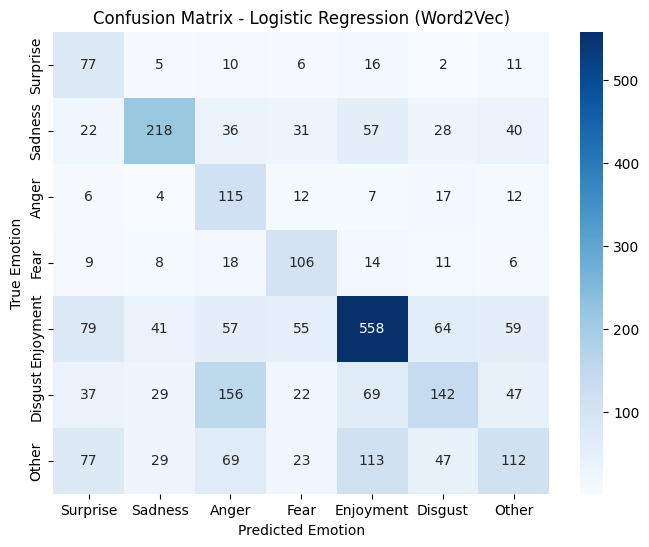

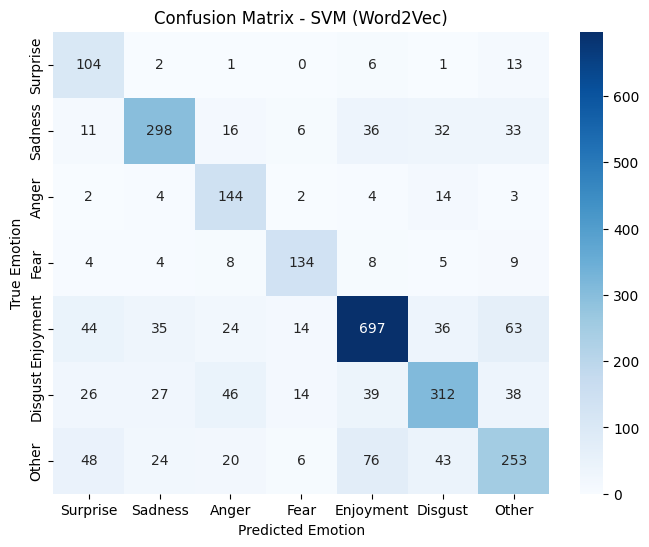

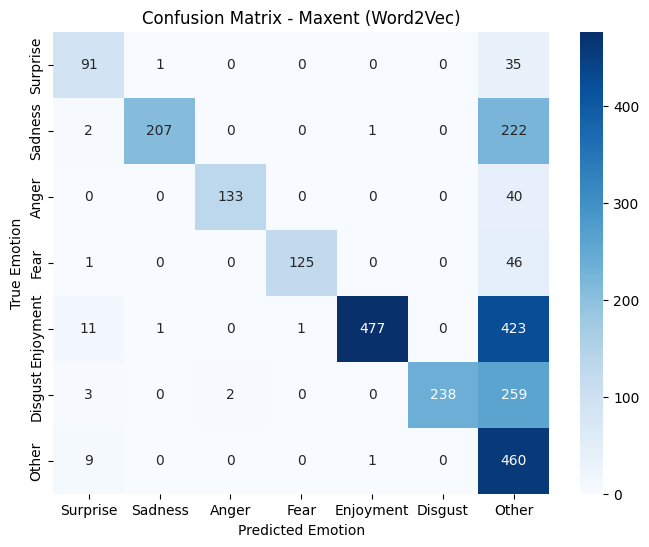

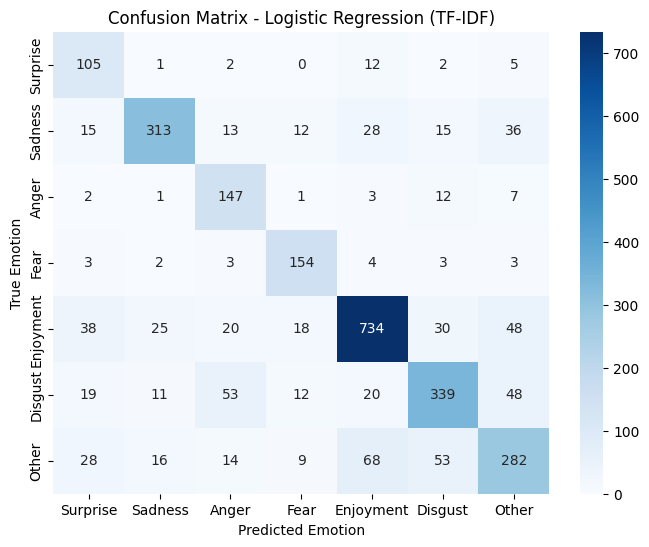

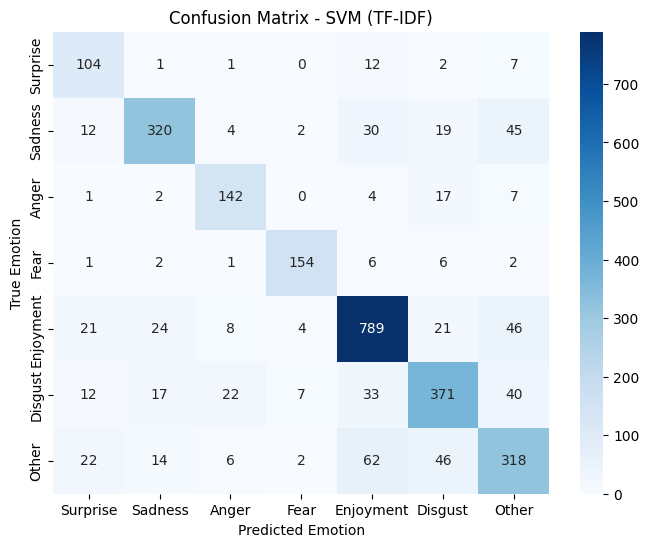

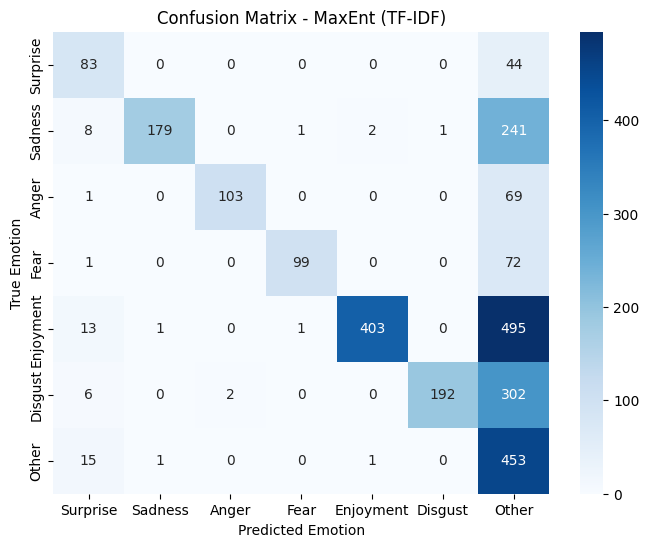

In [ ]:
# Plot confusion matrices
plot_confusion_matrix(test_df['Emotion'], y_test_pred_lr, 'Confusion Matrix - Logistic Regression (Word2Vec)')
plot_confusion_matrix(test_df['Emotion'], y_test_pred_svm, 'Confusion Matrix - SVM (Word2Vec)')
plot_confusion_matrix(test_df['Emotion'], y_test_pred_maxent, 'Confusion Matrix - Maxent (Word2Vec)')
plot_confusion_matrix(test_df['Emotion'], y_test_pred_tf_lr, 'Confusion Matrix - Logistic Regression (TF-IDF)')
plot_confusion_matrix(test_df['Emotion'], y_test_pred_tf_svm, 'Confusion Matrix - SVM (TF-IDF)')
plot_confusion_matrix(test_df['Emotion'], y_test_pred_tf_maxent, 'Confusion Matrix - MaxEnt (TF-IDF)')

# **4. Dự đoán**

## **4.1. Các mô hình sử dụng TF-IDF**

In [ ]:
with open(folder + '/models/tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open(folder + '/models/logistic_tfidf.pkl', 'rb') as file:
    logistic_tf_model = pickle.load(file)

with open(folder + '/models/svm_tfidf.pkl', 'rb') as file:
    svm_tf_model = pickle.load(file)

with open(folder + '/models/maxent_tfidf.pkl', 'rb') as file:
    maxent_tf_model = pickle.load(file)

In [ ]:
def predict_emotion_tf(text, model_name='logistic'):
    text = tokenize(text)
    text = remove_stopwords(text)
    text = tfidf_vectorizer.transform([' '.join(text)])

    if model_name == 'logistic':
        label_idx = logistic_tf_model.predict(text)[0]
    elif model_name == 'svm':
        label_idx = svm_tf_model.predict(text)[0]
    elif model_name == 'maxent':
        label_idx = maxent_tf_model.classify({'features': tuple(text.toarray()[0].tolist())})
    else:
        return "Invalid model name"

    return num_to_emotion[label_idx]

In [ ]:
# Ví dụ sử dụng
text = "buồn thiệt á"
print("Text:", text)

predicted_emotion_logistic = predict_emotion_tf(text, 'logistic')
print(f"Logistic Regression dự đoán: {predicted_emotion_logistic}")

predicted_emotion_svm = predict_emotion_tf(text, 'svm')
print(f"SVM dự đoán: {predicted_emotion_svm}")

predicted_emotion_maxent = predict_emotion_tf(text, 'maxent')
print(f"Maxent dự đoán: {predicted_emotion_maxent}")

Text: buồn thiệt á
Logistic Regression dự đoán: Sadness
SVM dự đoán: Sadness
Maxent dự đoán: Other


## **4.2. Các mô hình sử dụng Word2Vec**

In [ ]:
with open(folder + '/models/word2vec_model.pkl', 'rb') as file:
    word2vec_model = pickle.load(file)

with open(folder + '/models/logistic_w2v.pkl', 'rb') as file:
    logistic_w2v_model = pickle.load(file)

with open(folder + '/models/svm_w2v.pkl', 'rb') as file:
    svm_w2v_model = pickle.load(file)

with open(folder + '/models/maxent_w2v.pkl', 'rb') as file:
    maxent_w2v_model = pickle.load(file)

In [ ]:
def predict_emotion_w2v(text, model_name='logistic'):
    text = tokenize(text)
    text = remove_stopwords(text)
    vector = get_sentence_vector(text)
    vector = np.array(vector).reshape(1, -1)

    if model_name == 'logistic':
        label_idx = logistic_w2v_model.predict(vector)[0]
    elif model_name == 'svm':
        label_idx = svm_w2v_model.predict(vector)[0]
    elif model_name == 'maxent':
        label_idx = maxent_w2v_model.classify({'features': tuple(vector.tolist()[0])})
    else:
        return "Invalid model name"

    return num_to_emotion[label_idx]

In [ ]:
# Ví dụ sử dụng
text = "vui vẻ vui vẻ =))"
print("Text:", text)

predicted_emotion_logistic = predict_emotion_w2v(text, 'logistic')
print(f"Logistic Regression dự đoán: {predicted_emotion_logistic}")

predicted_emotion_svm = predict_emotion_w2v(text, 'svm')
print(f"SVM dự đoán: {predicted_emotion_svm}")

predicted_emotion_maxent = predict_emotion_w2v(text, 'maxent')
print(f"Maxent dự đoán: {predicted_emotion_maxent}")

Text: vui vẻ vui vẻ =))
Logistic Regression dự đoán: Fear
SVM dự đoán: Fear
Maxent dự đoán: Other


# **5. So sánh mô hình tốt nhất (SVM) đối với các câu có độ dài >= 20 và < 20**

Lấy ngẫu nhiên 100 mẫu chứa các câu có độ dài < 20 trong tập test ban đầu

In [ ]:
test_filtered_lower = test[test['Sentence'].str.split().str.len() < 20].sample(n=100, random_state=42)
test_filtered_lower.reset_index(inplace=True, drop=True)
test_filtered_lower

,Emotion,Sentence,Text
0,6,tao nghe nói đứa bé còn nhỏ là không được chụp...,"[_s_, tao, đứa, bé, chụp, hình, mày, _e_]"
1,4,gần thôi :))) giờ nhìn lại đề thi và không hiể...,"[_s_, _slightly_smiling_face_, đề, thi, trường..."
2,4,đạp xe xíu rã chân ông này đạp như tay đua xe,"[_s_, đạp, xe, xíu, rã, chân, đạp, tay_đua, xe..."
3,4,"diễn còn cứng quá à , kiểu biết rồi mà còn giả...","[_s_, diễn, cứng, ,, kiểu, giả_bộ, _slightly_s..."
4,4,con bé bị quơ trúng nhìn đẹp như búp bê ấy < 3,"[_s_, bé, quơ, trúng, đẹp, búp_bê, <, 3, _e_]"
...,...,...,...
95,6,đỗ ngay góc cua thế có ngày sứt mõm ??,"[_s_, đỗ, góc, cua, sứt, mõm, ?, _e_]"
96,1,đây là một câu chuyện buồn không chỉ riêng tao,"[_s_, câu_chuyện, buồn, tao, _e_]"
97,4,per hẹn xem phim này nữa nha mày 😛,"[_s_, per, hẹn, phim, nha, mày, _face_with_ton..."
98,4,"đỉnh rồi , hiệu ứng tốt :))) ấn tượng vãi_chưở...","[_s_, đỉnh, ,, hiệu_ứng, _slightly_smiling_fac..."


Lấy ngẫu nhiên 100 mẫu chứa các câu có độ dài >= 20 trong tập test ban đầu

In [ ]:
test_filtered_upper = test[test['Sentence'].str.split().str.len() >= 20].sample(n=100, random_state=42)
test_filtered_upper.reset_index(inplace=True, drop=True)
test_filtered_upper

,Emotion,Sentence,Text
0,4,"các cháu thật tốt , hãy thương yêu mọi người v...","[_s_, cháu, ,, thương_yêu, loài, vật, ,, may_m..."
1,1,tư ̀ hô ̀ i ba ̣ n â ́ y chuyê ̉ n trươ ̀ ngườ...,"[_s_, tư, ̀, hô, ̀, i, ̣, â, ́, y, chuyê, ̉, t..."
2,5,nhìn cái bản mặt bà ta mà ghét thay . tham vô ...,"[_s_, bản_mặt, ta, ghét, thay, ., tham, vô_độ,..."
3,1,bà tôi giờ mất mấy năm rồi giờ lớn lên rồi mà ...,"[_s_, mấy, chả, tặng, món, quà, _loudly_crying..."
4,6,"thời gian thấm nhuần yêu thương , nếu đủ kiên ...","[_s_, thấm_nhuần, yêu_thương, ,, kiên_nhẫn, hạ..."
...,...,...,...
95,3,"hôm nào đi học về cũng phải đi qa , nhà nuôi l...","[_s_, hôm, đi, học, đi, qa, ,, nuôi, lũ, đỉnh,..."
96,1,tao thấy tai nạn giao thông là tao nói với mẹ ...,"[_s_, tao, tai_nạn, giao_thông, tao, mẹ, ., .,..."
97,4,chắc chắn bố của bạn này là một người vui tính...,"[_s_, bố, vui_tính, khó_tính, ., khiếu, khôi_h..."
98,4,"phim này coi lâu lắm ùi , mà mỗi năm phải coi ...","[_s_, phim, coi, lắm, ,, coi, 1, -, 2, ,, cực_..."


Dự đoán và đánh giá mô hình SVM sử dụng phưng pháp chuyển đổi vector Word2Vec và TF-IDF đối với 2 tập test trên

In [ ]:
def evaluate_model(df, model_func):
    predictions = []
    for text in df["Sentence"]:
        predictions.append(model_func(text))
    return predictions

In [ ]:
def evaluate_predictions(true_labels, predicted_labels):
    predicted_labels = [emotion_to_num.get(label) for label in predicted_labels]

    accuracy = round(accuracy_score(true_labels, predicted_labels), 2)
    precision = round(precision_score(true_labels, predicted_labels, average='weighted'), 2)
    recall = round(recall_score(true_labels, predicted_labels, average='weighted'), 2)
    f1 = round(f1_score(true_labels, predicted_labels, average='weighted'), 2)
    return accuracy, precision, recall, f1

In [ ]:
tf_lower_predictions = evaluate_model(test_filtered_lower, predict_emotion_tf)
tf_upper_predictions = evaluate_model(test_filtered_upper, predict_emotion_tf)

w2v_lower_predictions = evaluate_model(test_filtered_lower, predict_emotion_w2v)
w2v_upper_predictions = evaluate_model(test_filtered_upper, predict_emotion_w2v)

tf_lower_results = pd.DataFrame({'Sentence': test_filtered_lower['Sentence'], 'Prediction': tf_lower_predictions})
tf_upper_results = pd.DataFrame({'Sentence': test_filtered_upper['Sentence'], 'Prediction': tf_upper_predictions})
w2v_lower_results = pd.DataFrame({'Sentence': test_filtered_lower['Sentence'], 'Prediction': w2v_lower_predictions})
w2v_upper_results = pd.DataFrame({'Sentence': test_filtered_upper['Sentence'], 'Prediction': w2v_upper_predictions})

In [ ]:
# SVM TF-IDF model
tf_lower_accuracy, tf_lower_precision, tf_lower_recall, tf_lower_f1 = evaluate_predictions(test_filtered_lower['Emotion'], tf_lower_predictions)
tf_upper_accuracy, tf_upper_precision, tf_upper_recall, tf_upper_f1 = evaluate_predictions(test_filtered_upper['Emotion'], tf_upper_predictions)

# SVM Word2Vec model
w2v_lower_accuracy, w2v_lower_precision, w2v_lower_recall, w2v_lower_f1 = evaluate_predictions(test_filtered_lower['Emotion'], w2v_lower_predictions)
w2v_upper_accuracy, w2v_upper_precision, w2v_upper_recall, w2v_upper_f1 = evaluate_predictions(test_filtered_upper['Emotion'], w2v_upper_predictions)

evaluation_results = pd.DataFrame({
    "Model": ["SVM TF-IDF (< 20)", "SVM TF-IDF (>= 20)",
              "SVM Word2Vec (< 20)", "SVM Word2Vec (>= 20)"],
    "Accuracy": [tf_lower_accuracy, tf_upper_accuracy,
                 w2v_lower_accuracy, w2v_upper_accuracy],
    "Precision": [tf_lower_precision, tf_upper_precision,
                  w2v_lower_precision, w2v_upper_precision],
    "Recall": [tf_lower_recall, tf_upper_recall,
               w2v_lower_recall, w2v_upper_recall],
    "F1 Score": [tf_lower_f1, tf_upper_f1,
                 w2v_lower_f1, w2v_upper_f1]
})

evaluation_results

,Model,Accuracy,Precision,Recall,F1 Score
0,SVM TF-IDF (< 20),0.48,0.55,0.48,0.50
1,SVM TF-IDF (>= 20),0.42,0.48,0.42,0.44
2,SVM Word2Vec (< 20),0.08,0.20,0.08,0.09
3,SVM Word2Vec (>= 20),0.09,0.14,0.09,0.09
